In [1]:
import glob

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

import data
import wifi_label_utils

In [4]:

def annotate(filename, label, avg_window_len, avg_duration=-1, debug=False):
    
    data_obj = data.Data(filename)

    # use a seconds worth of data to calculate threshold
    if avg_duration > -1:
        iq_samples = data_obj.get_samples(n_samples=int(data_obj.metadata["global"]["core:sample_rate"]*avg_duration))
    else:
        iq_samples = data_obj.get_samples()
        
    avg_pwr = wifi_label_utils.moving_average(iq_samples, avg_window_len)
    avg_pwr_db = 10*np.log10(avg_pwr)

    
    # guess_threshold = (np.max(avg_pwr_db) + np.mean(avg_pwr_db))/2
    guess_threshold = 1.05 * np.max(avg_pwr_db)
    
    if debug:
        print(f"{np.max(avg_pwr_db)=}")
        print(f"{np.mean(avg_pwr_db)=}")
        print(f"{guess_threshold=}")
        print(f"{len(avg_pwr_db)=}")
        
        plt.figure()
        plt.plot(avg_pwr_db[int(0*20480000e-2):int(10*20.48e6)])
        plt.axhline(y = guess_threshold, color = 'r', linestyle = '-') 
        plt.show()
        
    #wifi_label_utils.annotate_power_squelch(data_obj, label, guess_threshold, avg_window_len, skip_validate=True)


  0%|                                                                                                                       | 0/48 [00:00<?, ?it/s]


Loaded 
 Data file: data/gamutrf/gamutrf-sd-gr-ieee-wifi/wifi-encoding-6-sendsps-5000000.s16.zst.sigmf-data 
 SigMF-Meta file: data/gamutrf/gamutrf-sd-gr-ieee-wifi/wifi-encoding-6-sendsps-5000000.s16.zst.sigmf-meta

np.max(avg_pwr_db)=-60.135371595810376
np.mean(avg_pwr_db)=-62.28156346361472
guess_threshold=-63.1421401756009
len(avg_pwr_db)=204799745


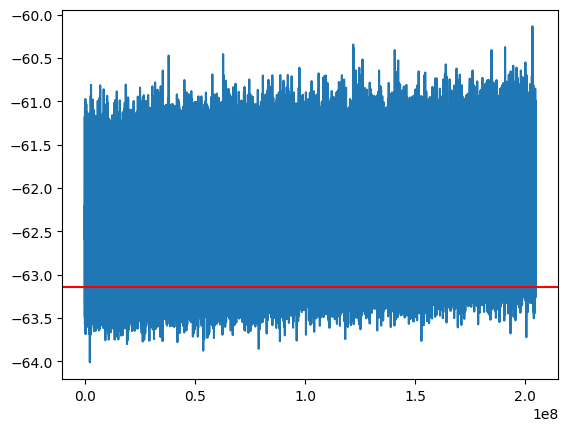

  0%|                                                                                                                       | 0/48 [00:46<?, ?it/s]


In [5]:
for f in tqdm(glob.glob("data/gamutrf/gamutrf-sd-gr-ieee-wifi/*.sigmf-meta")):
    annotate(f, label="anom_wifi", avg_window_len=256, avg_duration=10, debug=True)
    break
